In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

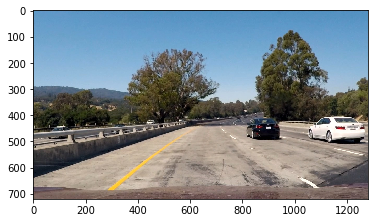

In [9]:
# prepare object points
nx = 8#TODO: enter the number of inside corners in x
ny = 6#TODO: enter the number of inside corners in y

# Make a list of calibration images
fname = 'test_images/test1.jpg'
img = cv2.cvtColor(cv2.imread(fname), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.show()

In [51]:
def crop(img):
    return img[400:-40, 160:-160]

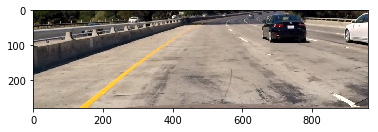

In [52]:
cropped = crop(img)
plt.imshow(cropped)
plt.show()